### **Practical Assignment - Machine Learning 1**
##### Work done by:

Beatriz Sá, up202105831

Francisco Ribeiro, up202104797

Marta Pereira, up202105713

#### ***Imports***

In [1]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from scipy.spatial.distance import euclidean
from collections import Counter, defaultdict
from IPython.display import display, HTML
from sklearn.datasets import fetch_openml

import auxiliarfunctions as af
import knn.knn as neighbors
import numpy as np
import pandas as pd

#### ***Display datasets***

In [2]:
def table_data(name, data):
    # Verifica se data é uma tupla (X, y)
    if isinstance(data, tuple) and len(data) == 2:
        X, y = data
        # Verifica se X e y são DataFrames ou Series e os transforma em DataFrame se necessário
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        if not isinstance(y, pd.DataFrame):
            y = pd.DataFrame(y)
        # Concatena X e y
        df = pd.concat([X, y], axis=1)
    else:
        # Se data não é uma tupla, assume que é um DataFrame único
        df = pd.DataFrame(data)
    # Exibe o nome do dataset
    
    display(HTML(df.head(5).to_html()))
    print("\n")

#### ***Loading the Datasets***

The datasets used in this notebook are extracted from OpenMl

In [3]:
datasets = []                                        # list of datasets that store tuples X, y

ids = [37,43465,61,40983,44,59,458,187,54,1464,1491,334] #[37,163,40498,187,41,1527,40983] #,1459
datasets_name = [
                 "Diabetes",                         # list of datasets names
                 "Boston-house-price-data",
                 "Iris",
                 "Wilt",
                 "Spambase",
                 "Ionosphere",
                 "Analcatdata_authorship",
                 "Wine Quality ",
                 "Vehicle",
                 "Blood-transfusion-service-center",
                 "One-hundred-plants-margin",
                 "Monks-problems-2"
                ]
    
for i in range(len(ids)):
    dataset = fetch_openml(data_id=ids[i])
    X = dataset.data
    y = dataset.target
    data = X, y
    name = datasets_name[i]
    print(f"Dataset: {name}")
    print(f"Before processing the dataset:")
    table_data(name,data)
    X,y = af.preprocess_data(X, y)
    data = X, y
    datasets.append(data)
    print(f"After processing the dataset:")
    table_data(name, data)



Dataset: Diabetes
Before processing the dataset:


,preg,plas,pres,skin,insu,mass,pedi,age,class
0,6,148,72,35,0,33.6,0.627,50,tested_positive
1,1,85,66,29,0,26.6,0.351,31,tested_negative
2,8,183,64,0,0,23.3,0.672,32,tested_positive
3,1,89,66,23,94,28.1,0.167,21,tested_negative
4,0,137,40,35,168,43.1,2.288,33,tested_positive




After processing the dataset:


,preg,plas,pres,skin,insu,mass,pedi,age,class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1




Dataset: Boston-house-price-data
Before processing the dataset:


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2




After processing the dataset:


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,137
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,113
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,196
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,193
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,203




Dataset: Iris
Before processing the dataset:


,sepallength,sepalwidth,petallength,petalwidth,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa




After processing the dataset:


,sepallength,sepalwidth,petallength,petalwidth,class
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0




Dataset: Wilt
Before processing the dataset:


,GLCM_Pan,Mean_G,Mean_R,Mean_NIR,SD_Plan,class
0,120.362774,205.500000,119.395349,416.581395,20.676318,2
1,124.739583,202.800000,115.333333,354.333333,16.707151,2
2,134.691964,199.285714,116.857143,477.857143,22.496712,2
3,127.946309,178.368421,92.368421,278.473684,14.977453,2
4,135.431548,197.000000,112.690476,532.952381,17.604193,2




After processing the dataset:


,GLCM_Pan,Mean_G,Mean_R,Mean_NIR,SD_Plan,class
0,120.362774,205.500000,119.395349,416.581395,20.676318,2
1,124.739583,202.800000,115.333333,354.333333,16.707151,2
2,134.691964,199.285714,116.857143,477.857143,22.496712,2
3,127.946309,178.368421,92.368421,278.473684,14.977453,2
4,135.431548,197.000000,112.690476,532.952381,17.604193,2




Dataset: Spambase
Before processing the dataset:


,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,word_freq_receive,word_freq_will,word_freq_people,word_freq_report,word_freq_addresses,word_freq_free,word_freq_business,word_freq_email,word_freq_you,word_freq_credit,word_freq_your,word_freq_font,word_freq_000,word_freq_money,word_freq_hp,word_freq_hpl,word_freq_george,word_freq_650,word_freq_lab,word_freq_labs,word_freq_telnet,word_freq_857,word_freq_data,word_freq_415,word_freq_85,word_freq_technology,word_freq_1999,word_freq_parts,word_freq_pm,word_freq_direct,word_freq_cs,word_freq_meeting,word_freq_original,word_freq_project,word_freq_re,word_freq_edu,word_freq_table,word_freq_conference,char_freq_%3B,char_freq_%28,char_freq_%5B,char_freq_%21,char_freq_%24,char_freq_%23,capital_run_length_average,capital_run_length_longest,capital_run_length_total,class
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,0.00,0.64,0.00,0.00,0.00,0.32,0.00,1.29,1.93,0.00,0.96,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,0.21,0.79,0.65,0.21,0.14,0.14,0.07,0.28,3.47,0.00,1.59,0.0,0.43,0.43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.07,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,0.38,0.45,0.12,0.00,1.75,0.06,0.06,1.03,1.36,0.32,0.51,0.0,1.16,0.06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.06,0.0,0.0,0.12,0.0,0.06,0.06,0.0,0.0,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,0.31,0.31,0.31,0.00,0.00,0.31,0.00,0.00,3.18,0.00,0.31,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,0.31,0.31,0.31,0.00,0.00,0.31,0.00,0.00,3.18,0.00,0.31,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1




After processing the dataset:


,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,word_freq_receive,word_freq_will,word_freq_people,word_freq_report,word_freq_addresses,word_freq_free,word_freq_business,word_freq_email,word_freq_you,word_freq_credit,word_freq_your,word_freq_font,word_freq_000,word_freq_money,word_freq_hp,word_freq_hpl,word_freq_george,word_freq_650,word_freq_lab,word_freq_labs,word_freq_telnet,word_freq_857,word_freq_data,word_freq_415,word_freq_85,word_freq_technology,word_freq_1999,word_freq_parts,word_freq_pm,word_freq_direct,word_freq_cs,word_freq_meeting,word_freq_original,word_freq_project,word_freq_re,word_freq_edu,word_freq_table,word_freq_conference,char_freq_%3B,char_freq_%28,char_freq_%5B,char_freq_%21,char_freq_%24,char_freq_%23,capital_run_length_average,capital_run_length_longest,capital_run_length_total,class
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,0.00,0.64,0.00,0.00,0.00,0.32,0.00,1.29,1.93,0.00,0.96,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,0.21,0.79,0.65,0.21,0.14,0.14,0.07,0.28,3.47,0.00,1.59,0.0,0.43,0.43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.07,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,0.38,0.45,0.12,0.00,1.75,0.06,0.06,1.03,1.36,0.32,0.51,0.0,1.16,0.06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.06,0.0,0.0,0.12,0.0,0.06,0.06,0.0,0.0,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,0.31,0.31,0.31,0.00,0.00,0.31,0.00,0.00,3.18,0.00,0.31,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,0.31,0.31,0.31,0.00,0.00,0.31,0.00,0.00,3.18,0.00,0.31,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1




Dataset: Ionosphere
Before processing the dataset:


,a01,a02,a03,a04,a05,a06,a07,a08,a09,a10,a11,a12,a13,a14,a15,a16,a17,a18,a19,a20,a21,a22,a23,a24,a25,a26,a27,a28,a29,a30,a31,a32,a33,a34,class
0,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,0.85243,-0.17755,0.59755,-0.44945,0.60536,-0.38223,0.84356,-0.38542,0.58212,-0.32192,0.56971,-0.29674,0.36946,-0.47357,0.56811,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,g
1,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,0.50874,-0.67743,0.34432,-0.69707,-0.51685,-0.97515,0.05499,-0.62237,0.33109,-1.00000,-0.13151,-0.45300,-0.18056,-0.35734,-0.20332,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,b
2,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,0.73082,0.05346,0.85443,0.00827,0.54591,0.00299,0.83775,-0.13644,0.75535,-0.08540,0.70887,-0.27502,0.43385,-0.12062,0.57528,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,g
3,1,0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-1.00000,0.14516,0.54094,-0.39330,-1.00000,-0.54467,-0.69975,1.00000,0.00000,0.00000,1.00000,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,b
4,1,0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,0.52798,-0.20275,0.56409,-0.00712,0.34395,-0.27457,0.52940,-0.21780,0.45107,-0.17813,0.05982,-0.35575,0.02309,-0.52879,0.03286,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,g




After processing the dataset:


,a01,a02,a03,a04,a05,a06,a07,a08,a09,a10,a11,a12,a13,a14,a15,a16,a17,a18,a19,a20,a21,a22,a23,a24,a25,a26,a27,a28,a29,a30,a31,a32,a33,a34,class
0,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,0.85243,-0.17755,0.59755,-0.44945,0.60536,-0.38223,0.84356,-0.38542,0.58212,-0.32192,0.56971,-0.29674,0.36946,-0.47357,0.56811,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,1
1,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,0.50874,-0.67743,0.34432,-0.69707,-0.51685,-0.97515,0.05499,-0.62237,0.33109,-1.00000,-0.13151,-0.45300,-0.18056,-0.35734,-0.20332,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,0
2,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,0.73082,0.05346,0.85443,0.00827,0.54591,0.00299,0.83775,-0.13644,0.75535,-0.08540,0.70887,-0.27502,0.43385,-0.12062,0.57528,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,1
3,1,0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-1.00000,0.14516,0.54094,-0.39330,-1.00000,-0.54467,-0.69975,1.00000,0.00000,0.00000,1.00000,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,0
4,1,0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,0.52798,-0.20275,0.56409,-0.00712,0.34395,-0.27457,0.52940,-0.21780,0.45107,-0.17813,0.05982,-0.35575,0.02309,-0.52879,0.03286,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,1




Dataset: Analcatdata_authorship
Before processing the dataset:


,a,all,also,an,and,any,are,as,at,be,been,but,by,can,do,down,even,every,for,from,had,has,have,her,his,if,in,into,is,it,its,may,more,must,my,no,not,now,of,on,one,only,or,our,should,so,some,such,than,that,the,their,then,there,things,this,to,up,upon,was,were,what,when,which,who,will,with,would,your,BookID,Author
0,46,12,0,3,66,9,4,16,13,13,4,8,8,1,0,1,5,0,21,12,16,3,6,62,3,3,30,3,9,14,1,2,6,5,0,10,16,2,54,7,8,1,7,0,4,7,1,3,3,17,67,6,2,5,1,4,47,2,3,40,11,7,5,6,8,4,9,1,0,1,Austen
1,35,10,0,7,44,4,3,18,16,9,3,9,14,2,5,1,2,4,14,8,14,2,6,42,1,2,22,5,11,21,1,1,7,4,8,10,11,3,57,10,5,2,6,1,4,11,7,6,5,17,76,6,2,7,0,7,48,1,1,27,13,5,7,7,3,5,14,8,0,1,Austen
2,46,2,0,3,40,1,13,11,9,23,11,13,13,4,7,3,0,8,15,2,12,5,20,17,9,6,31,1,16,27,1,3,7,4,10,6,19,8,41,7,7,1,7,2,5,10,7,4,8,10,48,4,3,4,1,6,46,1,1,24,6,10,4,6,4,5,15,3,9,1,Austen
3,40,7,0,4,64,3,3,20,13,20,7,11,6,1,1,4,0,6,20,3,26,2,4,33,4,2,26,0,12,11,3,0,6,1,3,7,15,3,62,11,2,3,4,1,5,7,0,3,6,16,80,13,3,3,1,7,43,1,1,26,10,3,6,10,5,3,22,4,3,1,Austen
4,29,5,0,6,52,5,14,17,6,16,12,8,9,5,3,2,0,6,17,8,10,2,19,18,4,4,38,3,12,22,5,0,4,6,4,8,21,4,69,4,6,6,15,3,2,12,5,5,1,13,87,10,0,3,1,5,34,3,1,23,5,8,4,13,2,4,21,10,0,1,Austen




After processing the dataset:


,a,all,also,an,and,any,are,as,at,be,been,but,by,can,do,down,even,every,for,from,had,has,have,her,his,if,in,into,is,it,its,may,more,must,my,no,not,now,of,on,one,only,or,our,should,so,some,such,than,that,the,their,then,there,things,this,to,up,upon,was,were,what,when,which,who,will,with,would,your,BookID,Author
0,46,12,0,3,66,9,4,16,13,13,4,8,8,1,0,1,5,0,21,12,16,3,6,62,3,3,30,3,9,14,1,2,6,5,0,10,16,2,54,7,8,1,7,0,4,7,1,3,3,17,67,6,2,5,1,4,47,2,3,40,11,7,5,6,8,4,9,1,0,1,0
1,35,10,0,7,44,4,3,18,16,9,3,9,14,2,5,1,2,4,14,8,14,2,6,42,1,2,22,5,11,21,1,1,7,4,8,10,11,3,57,10,5,2,6,1,4,11,7,6,5,17,76,6,2,7,0,7,48,1,1,27,13,5,7,7,3,5,14,8,0,1,0
2,46,2,0,3,40,1,13,11,9,23,11,13,13,4,7,3,0,8,15,2,12,5,20,17,9,6,31,1,16,27,1,3,7,4,10,6,19,8,41,7,7,1,7,2,5,10,7,4,8,10,48,4,3,4,1,6,46,1,1,24,6,10,4,6,4,5,15,3,9,1,0
3,40,7,0,4,64,3,3,20,13,20,7,11,6,1,1,4,0,6,20,3,26,2,4,33,4,2,26,0,12,11,3,0,6,1,3,7,15,3,62,11,2,3,4,1,5,7,0,3,6,16,80,13,3,3,1,7,43,1,1,26,10,3,6,10,5,3,22,4,3,1,0
4,29,5,0,6,52,5,14,17,6,16,12,8,9,5,3,2,0,6,17,8,10,2,19,18,4,4,38,3,12,22,5,0,4,6,4,8,21,4,69,4,6,6,15,3,2,12,5,5,1,13,87,10,0,3,1,5,34,3,1,23,5,8,4,13,2,4,21,10,0,1,0




Dataset: Wine Quality 
Before processing the dataset:


,Alcohol,Malic_acid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,OD280%2FOD315_of_diluted_wines,Proline,class
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1




After processing the dataset:


,Alcohol,Malic_acid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,OD280%2FOD315_of_diluted_wines,Proline,class
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1




Dataset: Vehicle
Before processing the dataset:


,COMPACTNESS,CIRCULARITY,DISTANCE_CIRCULARITY,RADIUS_RATIO,PR.AXIS_ASPECT_RATIO,MAX.LENGTH_ASPECT_RATIO,SCATTER_RATIO,ELONGATEDNESS,PR.AXIS_RECTANGULARITY,MAX.LENGTH_RECTANGULARITY,SCALED_VARIANCE_MAJOR,SCALED_VARIANCE_MINOR,SCALED_RADIUS_OF_GYRATION,SKEWNESS_ABOUT_MAJOR,SKEWNESS_ABOUT_MINOR,KURTOSIS_ABOUT_MAJOR,KURTOSIS_ABOUT_MINOR,HOLLOWS_RATIO,Class
0,95,48,83,178,72,10,162,42,20,159,176,379,184,70,6,16,187,197,van
1,91,41,84,141,57,9,149,45,19,143,170,330,158,72,9,14,189,199,van
2,104,50,106,209,66,10,207,32,23,158,223,635,220,73,14,9,188,196,saab
3,93,41,82,159,63,9,144,46,19,143,160,309,127,63,6,10,199,207,van
4,85,44,70,205,103,52,149,45,19,144,241,325,188,127,9,11,180,183,bus




After processing the dataset:


,COMPACTNESS,CIRCULARITY,DISTANCE_CIRCULARITY,RADIUS_RATIO,PR.AXIS_ASPECT_RATIO,MAX.LENGTH_ASPECT_RATIO,SCATTER_RATIO,ELONGATEDNESS,PR.AXIS_RECTANGULARITY,MAX.LENGTH_RECTANGULARITY,SCALED_VARIANCE_MAJOR,SCALED_VARIANCE_MINOR,SCALED_RADIUS_OF_GYRATION,SKEWNESS_ABOUT_MAJOR,SKEWNESS_ABOUT_MINOR,KURTOSIS_ABOUT_MAJOR,KURTOSIS_ABOUT_MINOR,HOLLOWS_RATIO,Class
0,95,48,83,178,72,10,162,42,20,159,176,379,184,70,6,16,187,197,3
1,91,41,84,141,57,9,149,45,19,143,170,330,158,72,9,14,189,199,3
2,104,50,106,209,66,10,207,32,23,158,223,635,220,73,14,9,188,196,2
3,93,41,82,159,63,9,144,46,19,143,160,309,127,63,6,10,199,207,3
4,85,44,70,205,103,52,149,45,19,144,241,325,188,127,9,11,180,183,0




Dataset: Blood-transfusion-service-center
Before processing the dataset:


,V1,V2,V3,V4,Class
0,2,50,12500,98,2
1,0,13,3250,28,2
2,1,16,4000,35,2
3,2,20,5000,45,2
4,1,24,6000,77,1




After processing the dataset:


,V1,V2,V3,V4,Class
0,2,50,12500,98,2
1,0,13,3250,28,2
2,1,16,4000,35,2
3,2,20,5000,45,2
4,1,24,6000,77,1




Dataset: One-hundred-plants-margin
Before processing the dataset:


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,Class
0,0.003906,0.003906,0.027344,0.033203,0.007812,0.017578,0.023438,0.005859,0.000000,0.015625,0.015625,0.015625,0.025391,0.000000,0.015625,0.0,0.025391,0.027344,0.033203,0.009766,0.025391,0.001953,0.0,0.003906,0.001953,0.044922,0.000000,0.031250,0.033203,0.015625,0.003906,0.000000,0.013672,0.001953,0.015625,0.015625,0.017578,0.033203,0.015625,0.003906,0.003906,0.031250,0.035156,0.015625,0.044922,0.007812,0.029297,0.037109,0.000000,0.027344,0.005859,0.001953,0.041016,0.000000,0.011719,0.000000,0.005859,0.035156,0.027344,0.033203,0.001953,0.000000,0.017578,0.0,1
1,0.005859,0.013672,0.027344,0.025391,0.013672,0.029297,0.019531,0.000000,0.001953,0.021484,0.007812,0.003906,0.013672,0.003906,0.009766,0.0,0.044922,0.011719,0.007812,0.031250,0.017578,0.001953,0.0,0.001953,0.001953,0.037109,0.000000,0.029297,0.025391,0.039062,0.003906,0.000000,0.035156,0.000000,0.027344,0.015625,0.019531,0.029297,0.023438,0.005859,0.003906,0.017578,0.025391,0.011719,0.025391,0.005859,0.035156,0.033203,0.000000,0.015625,0.011719,0.003906,0.037109,0.001953,0.017578,0.000000,0.021484,0.017578,0.046875,0.005859,0.003906,0.003906,0.046875,0.0,1
2,0.011719,0.001953,0.027344,0.044922,0.017578,0.042969,0.023438,0.000000,0.003906,0.019531,0.017578,0.005859,0.009766,0.005859,0.015625,0.0,0.027344,0.017578,0.019531,0.019531,0.023438,0.001953,0.0,0.011719,0.001953,0.042969,0.000000,0.011719,0.023438,0.035156,0.001953,0.001953,0.027344,0.000000,0.003906,0.017578,0.027344,0.033203,0.007812,0.001953,0.007812,0.035156,0.015625,0.011719,0.027344,0.003906,0.011719,0.019531,0.001953,0.013672,0.005859,0.007812,0.068359,0.003906,0.035156,0.000000,0.015625,0.021484,0.056641,0.009766,0.003906,0.000000,0.015625,0.0,1
3,0.013672,0.011719,0.037109,0.017578,0.011719,0.087891,0.023438,0.000000,0.000000,0.027344,0.021484,0.009766,0.013672,0.001953,0.013672,0.0,0.021484,0.017578,0.011719,0.027344,0.009766,0.003906,0.0,0.011719,0.000000,0.050781,0.001953,0.019531,0.013672,0.011719,0.003906,0.000000,0.027344,0.000000,0.013672,0.007812,0.017578,0.035156,0.021484,0.000000,0.003906,0.035156,0.027344,0.015625,0.029297,0.007812,0.011719,0.023438,0.000000,0.017578,0.009766,0.007812,0.052734,0.003906,0.015625,0.001953,0.021484,0.029297,0.033203,0.003906,0.000000,0.001953,0.027344,0.0,1
4,0.007812,0.009766,0.027344,0.025391,0.001953,0.005859,0.015625,0.000000,0.005859,0.017578,0.039062,0.007812,0.042969,0.001953,0.007812,0.0,0.017578,0.027344,0.025391,0.003906,0.019531,0.003906,0.0,0.009766,0.003906,0.017578,0.001953,0.009766,0.031250,0.015625,0.001953,0.001953,0.037109,0.000000,0.011719,0.037109,0.015625,0.039062,0.009766,0.001953,0.000000,0.050781,0.023438,0.005859,0.058594,0.003906,0.015625,0.021484,0.001953,0.015625,0.023438,0.005859,0.027344,0.000000,0.023438,0.001953,0.021484,0.048828,0.056641,0.019531,0.000000,0.000000,0.013672,0.0,1




After processing the dataset:


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,Class
0,0.003906,0.003906,0.027344,0.033203,0.007812,0.017578,0.023438,0.005859,0.000000,0.015625,0.015625,0.015625,0.025391,0.000000,0.015625,0.0,0.025391,0.027344,0.033203,0.009766,0.025391,0.001953,0.0,0.003906,0.001953,0.044922,0.000000,0.031250,0.033203,0.015625,0.003906,0.000000,0.013672,0.001953,0.015625,0.015625,0.017578,0.033203,0.015625,0.003906,0.003906,0.031250,0.035156,0.015625,0.044922,0.007812,0.029297,0.037109,0.000000,0.027344,0.005859,0.001953,0.041016,0.000000,0.011719,0.000000,0.005859,0.035156,0.027344,0.033203,0.001953,0.000000,0.017578,0.0,1
1,0.005859,0.013672,0.027344,0.025391,0.013672,0.029297,0.019531,0.000000,0.001953,0.021484,0.007812,0.003906,0.013672,0.003906,0.009766,0.0,0.044922,0.011719,0.007812,0.031250,0.017578,0.001953,0.0,0.001953,0.001953,0.037109,0.000000,0.029297,0.025391,0.039062,0.003906,0.000000,0.035156,0.000000,0.027344,0.015625,0.019531,0.029297,0.023438,0.005859,0.003906,0.017578,0.025391,0.011719,0.025391,0.005859,0.035156,0.033203,0.000000,0.015625,0.011719,0.003906,0.037109,0.001953,0.017578,0.000000,0.021484,0.017578,0.046875,0.005859,0.003906,0.003906,0.046875,0.0,1
2,0.011719,0.001953,0.027344,0.044922,0.017578,0.042969,0.023438,0.000000,0.003906,0.019531,0.017578,0.005859,0.009766,0.005859,0.015625,0.0,0.027344,0.017578,0.019531,0.019531,0.023438,0.001953,0.0,0.011719,0.001953,0.042969,0.000000,0.011719,0.023438,0.035156,0.001953,0.001953,0.027344,0.000000,0.003906,0.017578,0.027344,0.033203,0.007812,0.001953,0.007812,0.035156,0.015625,0.011719,0.027344,0.003906,0.011719,0.019531,0.001953,0.013672,0.005859,0.007812,0.068359,0.003906,0.035156,0.000000,0.015625,0.021484,0.056641,0.009766,0.003906,0.000000,0.015625,0.0,1
3,0.013672,0.011719,0.037109,0.017578,0.011719,0.087891,0.023438,0.000000,0.000000,0.027344,0.021484,0.009766,0.013672,0.001953,0.013672,0.0,0.021484,0.017578,0.011719,0.027344,0.009766,0.003906,0.0,0.011719,0.000000,0.050781,0.001953,0.019531,0.013672,0.011719,0.003906,0.000000,0.027344,0.000000,0.013672,0.007812,0.017578,0.035156,0.021484,0.000000,0.003906,0.035156,0.027344,0.015625,0.029297,0.007812,0.011719,0.023438,0.000000,0.017578,0.009766,0.007812,0.052734,0.003906,0.015625,0.001953,0.021484,0.029297,0.033203,0.003906,0.000000,0.001953,0.027344,0.0,1
4,0.007812,0.009766,0.027344,0.025391,0.001953,0.005859,0.015625,0.000000,0.005859,0.017578,0.039062,0.007812,0.042969,0.001953,0.007812,0.0,0.017578,0.027344,0.025391,0.003906,0.019531,0.003906,0.0,0.009766,0.003906,0.017578,0.001953,0.009766,0.031250,0.015625,0.001953,0.001953,0.037109,0.000000,0.011719,0.037109,0.015625,0.039062,0.009766,0.001953,0.000000,0.050781,0.023438,0.005859,0.058594,0.003906,0.015625,0.021484,0.001953,0.015625,0.023438,0.005859,0.027344,0.000000,0.023438,0.001953,0.021484,0.048828,0.056641,0.019531,0.000000,0.000000,0.013672,0.0,1




Dataset: Monks-problems-2
Before processing the dataset:


,attr1,attr2,attr3,attr4,attr5,attr6,class
0,1,1,1,1,2,2,0
1,1,1,1,1,4,1,0
2,1,1,1,2,1,1,0
3,1,1,1,2,1,2,0
4,1,1,1,2,2,1,0




After processing the dataset:


,attr1_2,attr1_3,attr2_2,attr2_3,attr3_2,attr4_2,attr4_3,attr5_2,attr5_3,attr5_4,attr6_2,class
0,0,0,0,0,0,0,0,1,0,0,1,0
1,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,1,0
4,0,0,0,0,0,1,0,1,0,0,0,0


#### ***Visualization of datasets***

To help visualize the data, we used PCA to reduce the dimensionality of the data to 2D

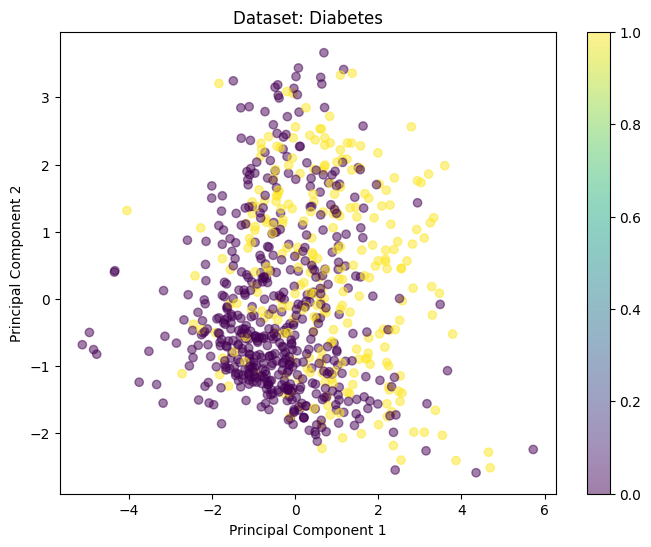

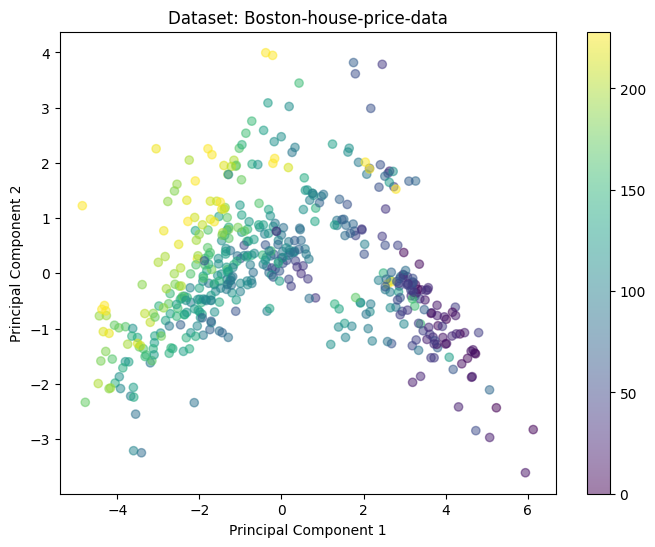

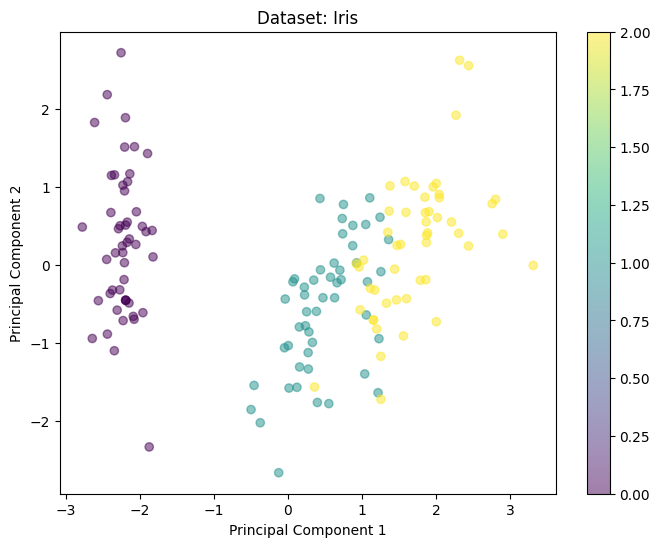

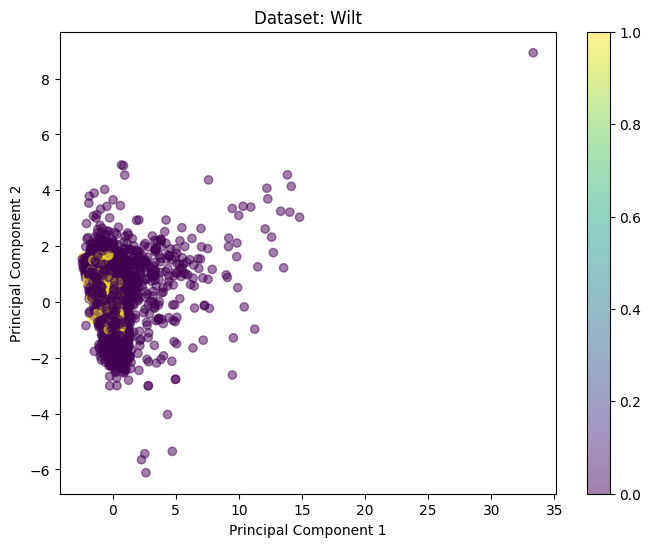

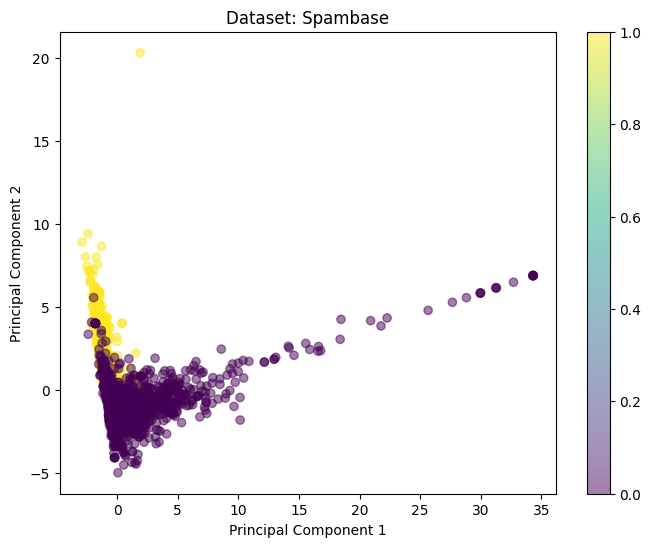

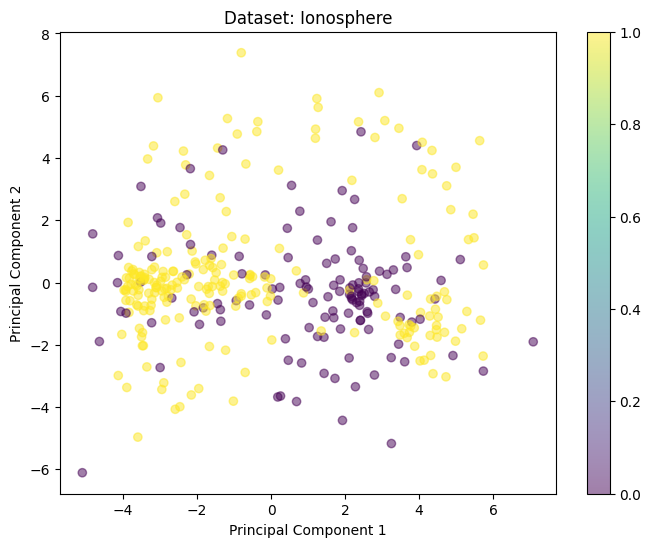

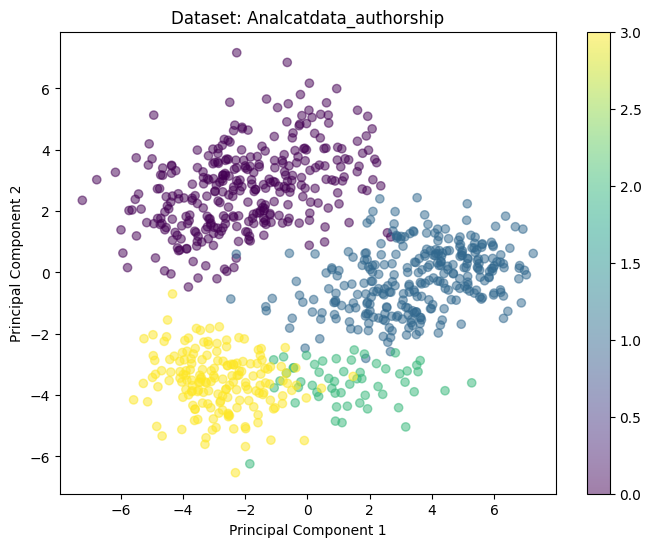

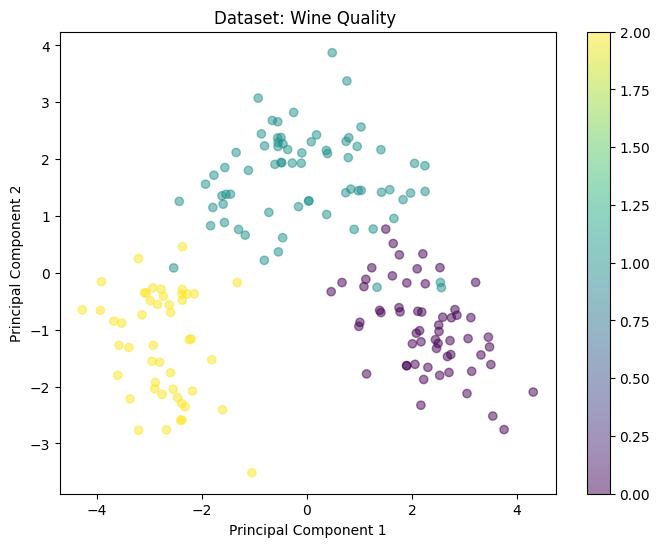

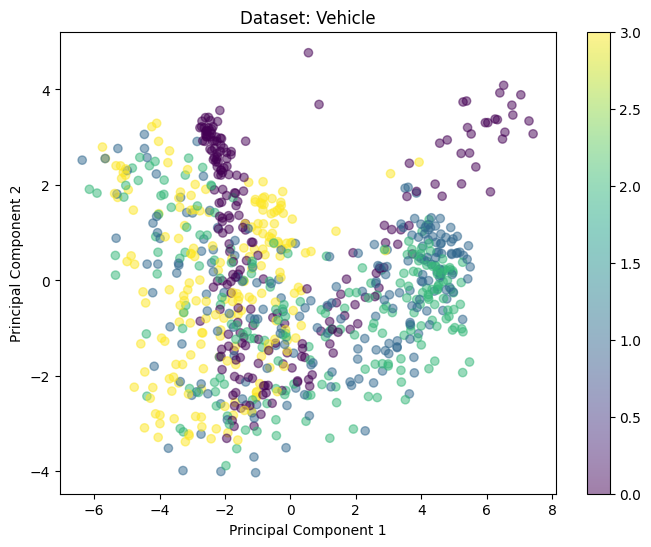

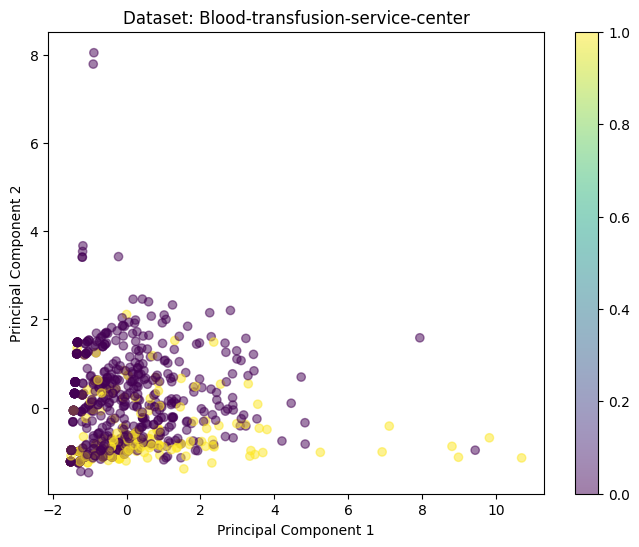

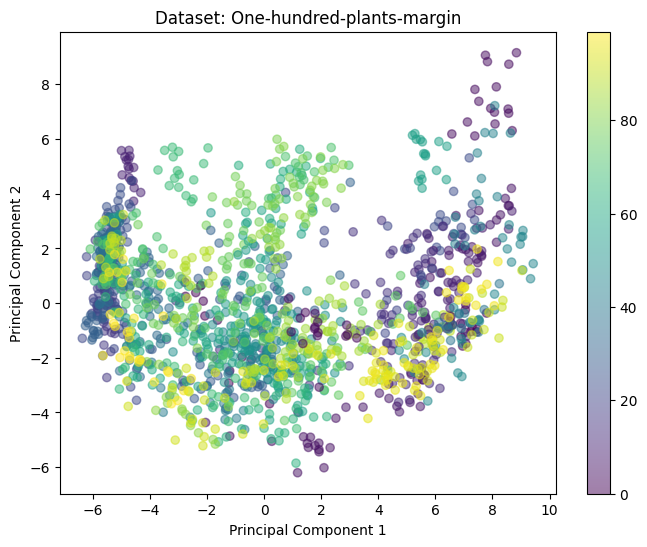

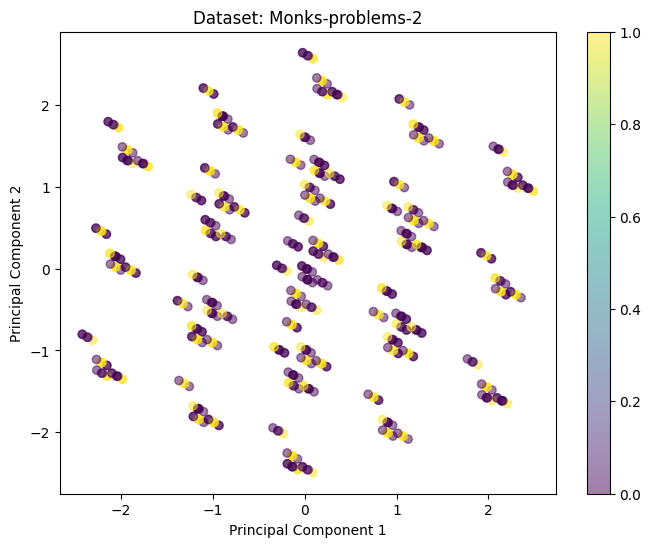

In [4]:
for i in range(len(ids)):
    af.apply_pca_and_plot_with_encoding(datasets[i][0], datasets[i][1],datasets_name[i])

#### ***Modifications of knn***

One of the modifications we propose is the assignment of a weight, given by the Local Outlier Factor or the Isolation Forest, which are methods used to identify outliers in datasets, during the training phase.

The LOF evaluates the "abnormality" of each data point in relation to its local neighbors, rather than considering the global distribution of the data. The LOF assigns a score to each point, where a value close to 1 indicates that the point has a density similar to its neighbors (it is not an outlier), while values greater than 1 indicate a higher probability of the point being an outlier.

On the other hand, the IF constructs several decision trees (isolation trees), where each tree is created by randomly selecting a feature and a split value. Data points that are quickly isolated (in fewer splits) are considered outliers because it is easier to isolate anomalous points than normal points. In the end, each point receives a score based on the number of splits required to isolate it. Points that require fewer splits to be isolated receive higher scores (indicating that they are outliers).

A outra modificação que propomos é a atribuição de uma maior ou menor importância aos k pontos mais próximos do novo ponto no momento de previsão. Isto é, pontos mais próximos do novo terão um maior "voto" do que os mais distantes.

In [1]:
class BaseEstimatorModified:
    y_required = True
    fit_required = True
    def __init__(self, outlier_detector = None):
        self.outlier_detector = outlier_detector
    

    def _setup_input(self, X, y=None):
        """Ensure inputs to an estimator are in the expected format.

        Ensures X and y are stored as numpy ndarrays by converting from an
        array-like object if necessary. Enables estimators to define whether
        they require a set of y target values or not with y_required, e.g.
        kmeans clustering requires no target labels and is fit against only X.

        Parameters
        ----------
        X : array-like
            Feature dataset.
        y : array-like
            Target values. By default is required, but if y_required = false
            then may be omitted.
        """
        #modificaçao
        anomaly_detector = self.outlier_detector
        anomaly_detector.fit(X) 
        
        if hasattr(anomaly_detector, 'negative_outlier_factor_'): # LOF
            weight = anomaly_detector.negative_outlier_factor_
        else:
            weight = anomaly_detector.score_samples(X)

        # -> colocar entre 0 e 1, onde 0 é 100% oulier e 1 é 100% um ponto normal
        if max(weight) == min(weight):
            self.weight = (weight - min(weight))
        else: 
            self.weight = (weight - min(weight)) / (max(weight) - min(weight))

        if not isinstance(X, np.ndarray):
            X = np.array(X)

        if X.size == 0:
            raise ValueError("Got an empty matrix.")

        if X.ndim == 1:
            self.n_samples, self.n_features = 1, X.shape
        else:
            self.n_samples, self.n_features = X.shape[0], np.prod(X.shape[1:])

        self.X = X

        if self.y_required:
            if y is None:
                raise ValueError("Missed required argument y")

            if not isinstance(y, np.ndarray):
                y = np.array(y)

            if y.size == 0:
                raise ValueError("The targets array must be no-empty.")

        self.y = y

    def fit(self, X, y=None):
        self._setup_input(X, y)

    def predict(self, X=None):
        if not isinstance(X, np.ndarray):
            X = np.array(X)

        if self.X is not None or not self.fit_required:
            return self._predict(X)
        else:
            raise ValueError("You must call `fit` before `predict`")

    def _predict(self, X=None):
        raise NotImplementedError()
    

In [6]:
class KNNBaseModified(BaseEstimatorModified):
    def __init__(self, k=5,  outlier_detector = None,distance_func = euclidean):
        """Base class for Nearest neighbors classifier and regressor.

        Parameters
        ----------
        k : int, default 5
            The number of neighbors to take into account. If 0, all the
            training examples are used.
        distance_func : function, default euclidean distance
            A distance function taking two arguments. Any function from
            scipy.spatial.distance will do.
        """
        super().__init__(outlier_detector)
        self.k = None if k == 0 else k  # l[:None] returns the whole list
        self.distance_func = distance_func
        
    def aggregate(self):
        raise NotImplementedError()

    def _predict(self, X=None):

        predictions = [self._predict_x(x) for x in X]  

        return np.array(predictions)

    def _predict_x(self, x):
        """Predict the label of a single instance x."""

        distances = (self.distance_func(x, example) for example in self.X)

        # agrupa a distancia, target e o peso e depois ordena a lista de forma crescente em relaçao as distancias
        neighbors = sorted(((dist, target,weigth) for (dist, target,weigth) in zip(distances, self.y, self.weight)), key=lambda x: x[0])

        # reduz a lista para conter apenas os k valores mais proximos e modifica a lista para target e peso
        neighbors_targets = [(target,weigth) for (_, target, weigth) in neighbors[: self.k]]

        return self.aggregate(neighbors_targets, self.k)


#### ***Without assigning a value related to the approximation to the new point***

In [7]:
class KNNClassifierWithoutImportance(KNNBaseModified):
    """Nearest neighbors classifier.

    Note: if there is a tie for the most common label among the neighbors, then
    the predicted label is arbitrary."""

    def aggregate(self, neighbors_targets, size):
        """Return the most common target label."""          

        weighted_dict = defaultdict(float)

        for target, weight in neighbors_targets:  
            weighted_dict[target] += weight # value from LOF or IF
            
        weighted_dict = dict(weighted_dict)

        max_target = max(weighted_dict.items(), key=lambda item: item[1])
        
        max_target_key, _ = max_target

        return max_target_key

#### ***Assigning a value related to the approximation to the new point***

In [8]:
class KNNClassifierModefied(KNNBaseModified):
    """Nearest neighbors classifier.

    Note: if there is a tie for the most common label among the neighbors, then
    the predicted label is arbitrary."""

    def aggregate(self, neighbors_targets, size):
        """Return the most common target label."""
        n = size           

        weighted_dict = defaultdict(float)

        for target, weight in neighbors_targets:  
            weighted_dict[target] += ((n*weight)/size) 
            n -= 1
            
        weighted_dict = dict(weighted_dict)

        max_target = max(weighted_dict.items(), key=lambda item: item[1])
        
        max_target_key, _ = max_target

        return max_target_key

#### ***Classification***

The classification is done using the KNN algorithm, we still used the unmofied version of the algorithm to classify the data so we can have a baseline to compare the results with. We also use the assignment of a weight related to the approximation of the points to the new data point to compare whether this method improves the result or not.

In [9]:
ks = [3,5,7]
classifiersK = []
names = []
for K in ks:
    classifiers = [Pipeline([('classifier', neighbors.KNNClassifier(k=K))]),
                Pipeline([('classifier', KNNClassifierWithoutImportance(k=K, outlier_detector = IsolationForest(contamination=0.1)))]),
                Pipeline([('classifier', KNNClassifierWithoutImportance(k=K, outlier_detector = LocalOutlierFactor(n_neighbors=20)))]),   
                Pipeline([('classifier', KNNClassifierModefied(k=K, outlier_detector = IsolationForest(contamination=0.1)))]),
                Pipeline([('classifier', KNNClassifierModefied(k=K, outlier_detector = LocalOutlierFactor(n_neighbors=20)))])
                ]
    classifiers_names = ['KNN', 'KNN Modified with Isolation Forest without importance', 'KNN Modified with Local Outlier Factor without importance', 'KNN Modified with Isolation Forest', 'KNN Modified with Local Outlier Factor']
    classifiersK.append(classifiers)
    names.append(classifiers_names)


In [10]:
kf = KFold(n_splits=10, shuffle=True, random_state=1)

In [11]:
def perform_cross_validation(classifier, X, y):
    scores = cross_val_score(classifier, X, y, cv=kf, scoring='accuracy')

    return np.mean(scores)

#### ***Results***

In [15]:
for i in range(len(datasets)):
    print(f'Accuracy for dataset {datasets_name[i]}:')
    j = 0
    for classifiers, name in zip(classifiersK, names):
        print("valor do k:" ,ks[j])
        for classifier, class_name in zip(classifiers,name):
            accuracy  = perform_cross_validation(classifier, datasets[i][0], datasets[i][1])
            print(f'- {class_name}: {accuracy}')
        j += 1

Accuracy for dataset Diabetes:
valor do k: 3
- KNN: 0.6900034176349965
- KNN Modified with Isolation Forest without importance: 0.6887047163362953
- KNN Modified with Local Outlier Factor without importance: 0.6913021189336979
- KNN Modified with Isolation Forest: 0.6834757347915242
- KNN Modified with Local Outlier Factor: 0.687388926862611
valor do k: 5
- KNN: 0.719958988380041
- KNN Modified with Isolation Forest without importance: 0.7160628844839371
- KNN Modified with Local Outlier Factor without importance: 0.719958988380041
- KNN Modified with Isolation Forest: 0.7055878332194121
- KNN Modified with Local Outlier Factor: 0.7120642515379357
valor do k: 7
- KNN: 0.721308954203691
- KNN Modified with Isolation Forest without importance: 0.7226247436773752
- KNN Modified with Local Outlier Factor without importance: 0.721308954203691
- KNN Modified with Isolation Forest: 0.7134483937115516
- KNN Modified with Local Outlier Factor: 0.7225734791524265
Accuracy for dataset Boston-hous